# 3.0-Normalization and Embedding 

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-03-26"

## Introduction

Normalize data and create embedding of the CD45 negative fraction from the T0 (tumor resection)

## Libraries

In [2]:
options(warn=-1,verbose = FALSE)
suppressMessages(suppressWarnings({
library(Seurat)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggplot2)
library(scater) 
library(scran)
}))

## Parameters

In [3]:
#here::dr_here(show_reason = TRUE)
source(here::here("SCGRES_99_100/sc_analysis/misc/paths.R"))

"{clust}/{plt_dir}" %>%
  glue::glue() %>%
  here::here() %>%
  dir.create(path = .,
           showWarnings = FALSE,
           recursive = TRUE)

"{clust}/{robj_dir}" %>%
  glue::glue() %>%
  here::here() %>%
  dir.create(path = .,
           showWarnings = FALSE,
           recursive = TRUE)

set.seed(0)

## Load data

In [4]:
seurat_obj <- readRDS(here::here(glue::glue("{qc}/{robj_dir}/clean_combined_object_T0_CD45neg.rds")))
seurat_obj

An object of class Seurat 
30832 features across 18258 samples within 1 assay 
Active assay: RNA (30832 features, 0 variable features)

## Normalization and linear dimensional reduction

In [5]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [6]:
# compute the variance and mean of the log-expression values 
sce <- as.SingleCellExperiment(seurat_obj, assay="RNA")
gene_var <- modelGeneVar(sce)

tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=30)

plt <- gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")+
  geom_text(data=tops, aes(mean,total,label=rownames(tops)))

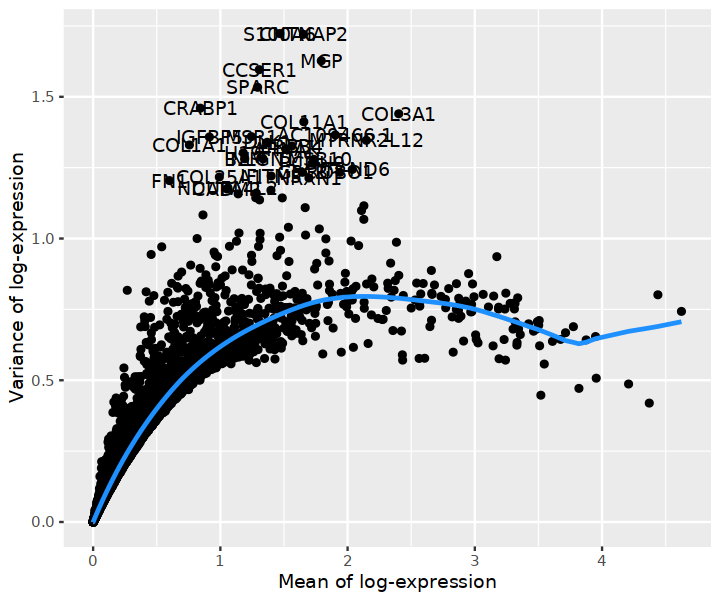

In [7]:
options(repr.plot.width = 6, repr.plot.height = 5)
plt

In [8]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 2392

In [9]:
VariableFeatures(seurat_obj) <- hvgs

In [ ]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  AC109466.1, NRXN1, ERBB4, PCDH9, MEG3, LRFN5, PEG3, COL11A1, PEG10, MDGA2 
	   CNTNAP2, ROBO1, NLGN1, GPC3, MEG8, AUTS2, MSR1, CCSER1, EYA1, DOK6 
	   FHIT, NRG3, TSHZ2, AP001977.1, PRPH, FRMD4A, SEMA3E, GRIP1, EPHA7, CADM2 
Negative:  COL4A1, COL4A2, A2M, SPARCL1, HLA-A, TAGLN2, MYO1B, MIR4435-2HG, ITGA1, ADGRF5 
	   MIF, IGFBP7, DLC1, EPAS1, ANGPT2, PDLIM1, COL18A1, BGN, SGIP1, MCAM 
	   CYTOR, MT2A, CAV1, ESAM, UBB, PALM2-AKAP2, ABCC9, FLT1, CRIM1, CDH13 
PC_ 2 
Positive:  ABCC9, OLFML2B, PDGFRB, ACTA2, ITGA4, RGS5, GUCY1B1, EPS8, COL6A3, EDNRA 
	   KCNJ8, TGFBI, GUCY1A2, AVPR1A, BGN, ZEB2, EGFLAM, TAGLN, NOTCH3, SEMA5A 
	   DAAM2, STEAP4, GJA4, SLIT3, CCDC102B, DOCK10, SEPTIN4, FAM13C, S1PR3, GEM 
Negative:  VWF, PLVAP, ESM1, ADGRL4, PECAM1, CD93, DIPK2B, CDH5, FOLH1, CAVIN2 
	   DLL4, RNASE1, NOTCH4, S1PR1, ECSCR, FLT1, ROBO4, IGFBP3, ENG, GRB10 
	   KDR, GIMAP4, ANO2, CD34, DYSF, ST6GALNAC3, PTPRB, DOCK4, PDGFD, PLCB1 
PC_ 3 
P

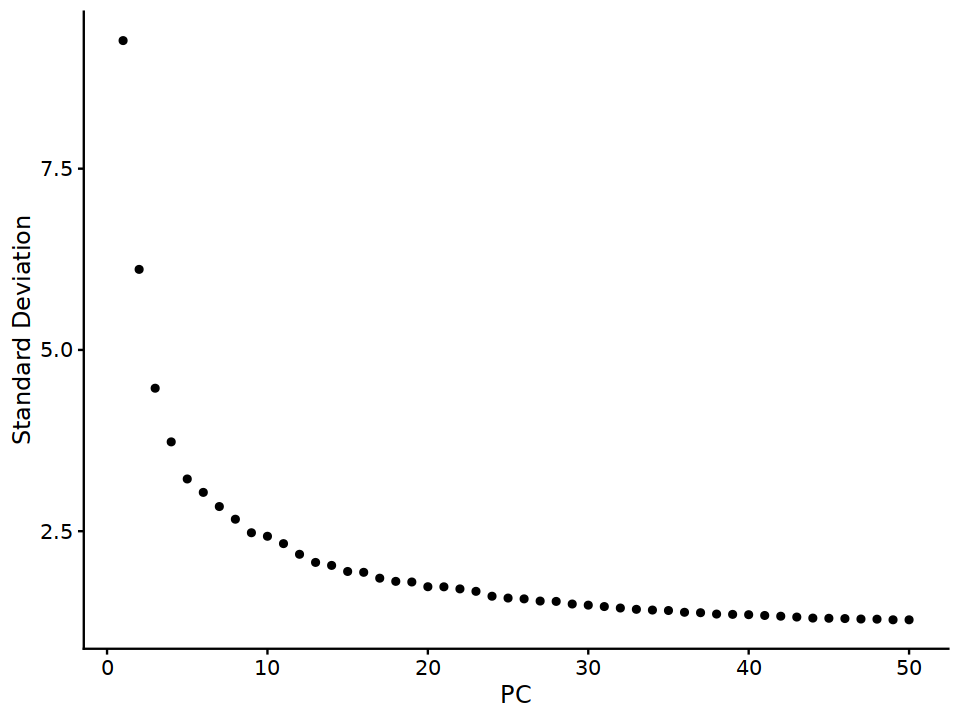

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

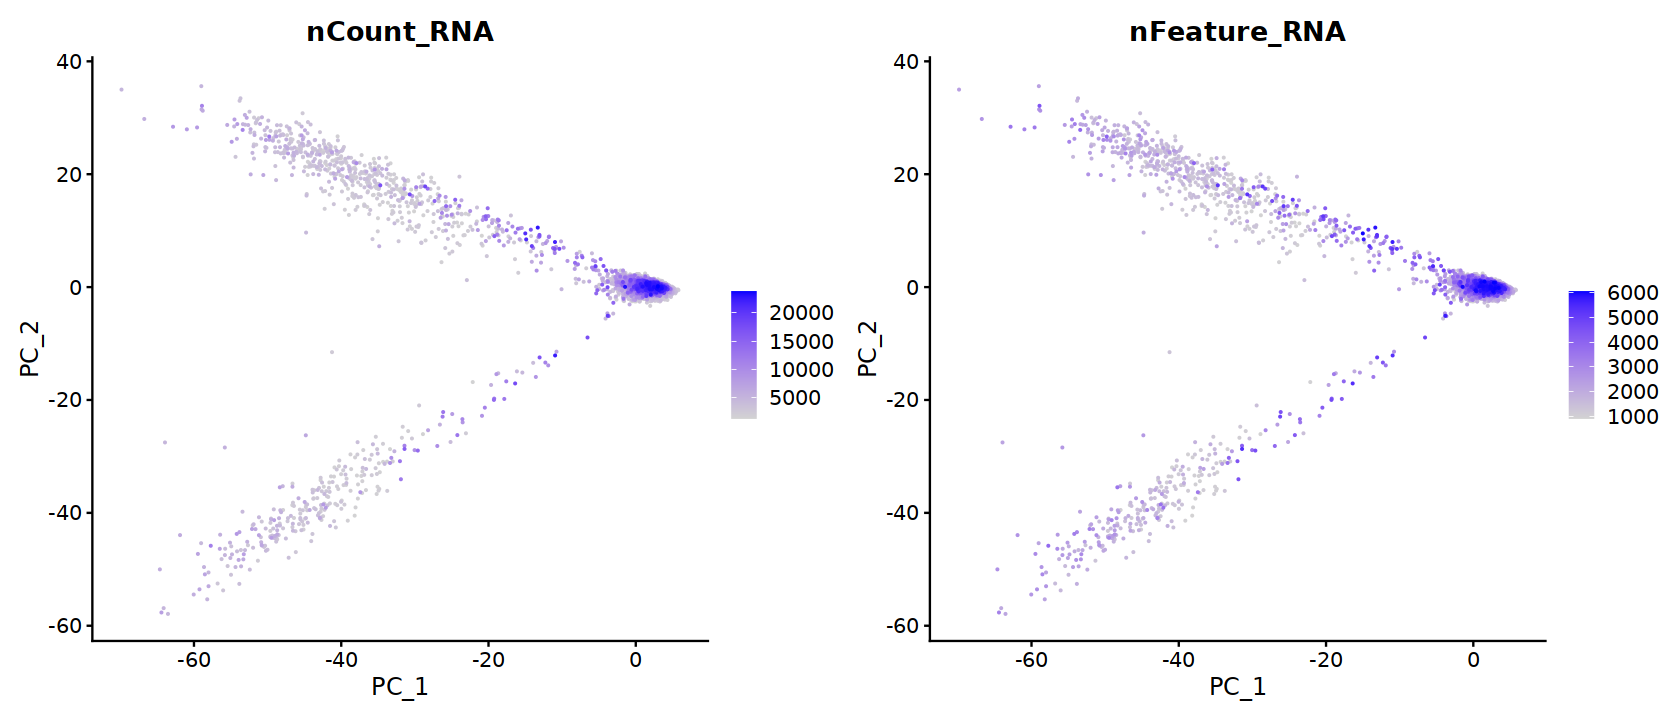

In [12]:
options(repr.plot.width = 14, repr.plot.height = 6)
FeaturePlot(object = seurat_obj, reduction = "pca",
        features = c("nCount_RNA","nFeature_RNA"), order=T)

In [13]:
# Calculate the variance explained 
stdev <- Stdev(seurat_obj, reduction = "pca")

var_explained <- (stdev^2) / sum(stdev^2) * 100

pc1_label <- paste0("PC1: ", round(var_explained[1], 2), "% var.")
pc2_label <- paste0("PC2: ", round(var_explained[2], 2), "% var.")

In [30]:
pcs <- c(pc1_label,pc2_label)

plts <- lapply(pcs, function(pc) {
    plt <- VizDimLoadings(seurat_obj,balanced=T, dims = match(pc, pcs), reduction = "pca", nfeatures=10) + 
    xlab(pc) +
    theme(plot.margin = unit(c(0.5,0.5,0.5,0.5), "cm"))
    plt
})

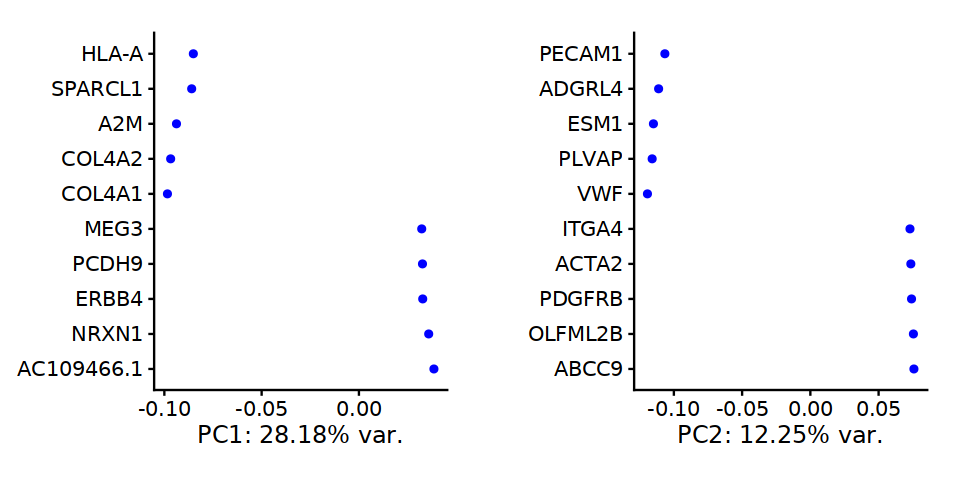

In [31]:
options(repr.plot.width = 8, repr.plot.height = 4)
cp <- cowplot::plot_grid(plotlist = plts,
                   align = "hv",
                   axis = "trbl",
                   ncol = 2,
                   nrow = 1)
cp

In [15]:
ProjectDim(seurat_obj, reduction = "pca")

PC_ 1 
Positive:  AC109466.1, NRXN1, ERBB4, PCDH9, MEG3, LRFN5, PEG3, COL11A1, PEG10, MDGA2 
	   CNTNAP2, ROBO1, NLGN1, GPC3, MEG8, AUTS2, MSR1, CCSER1, EYA1, DOK6 
Negative:  COL4A1, COL4A2, A2M, SPARCL1, HLA-A, TAGLN2, MYO1B, MIR4435-2HG, ITGA1, ADGRF5 
	   MIF, IGFBP7, DLC1, EPAS1, ANGPT2, PDLIM1, COL18A1, BGN, SGIP1, MCAM 
PC_ 2 
Positive:  ABCC9, OLFML2B, PDGFRB, ACTA2, ITGA4, RGS5, GUCY1B1, EPS8, COL6A3, EDNRA 
	   KCNJ8, TGFBI, GUCY1A2, AVPR1A, BGN, ZEB2, EGFLAM, TAGLN, NOTCH3, SEMA5A 
Negative:  VWF, PLVAP, ESM1, ADGRL4, PECAM1, CD93, DIPK2B, CDH5, FOLH1, CAVIN2 
	   DLL4, RNASE1, NOTCH4, S1PR1, ECSCR, FLT1, ROBO4, IGFBP3, ENG, GRB10 
PC_ 3 
Positive:  AUTS2, NRG3, LRFN5, FRMD4A, MEG8, AC109466.1, ROBO1, ERBB4, FHIT, IMMP2L 
	   NRXN1, RAD51B, MDGA2, GRIP1, MAML3, MAGI1, NEAT1, RORA, NLGN1, MT-ND6 
Negative:  TMSB4X, TMSB10, IFITM3, BST2, TIMP1, H2AFZ, LY6E, MGP, B2M, S100A1 
	   S100A4, TUBA1A, NDUFA4L2, TNNT1, S100A6, AL133415.1, IFITM1, MYL9, CKB, ID3 
PC_ 4 
Positive:  SLIT

An object of class Seurat 
30832 features across 18258 samples within 1 assay 
Active assay: RNA (30832 features, 2392 variable features)
 1 dimensional reduction calculated: pca

In [40]:
markers <- c("ERBB4", "PECAM1","ACTA2")

plts <- lapply(markers, function(x) {
    plt <- FeaturePlot(
        seurat_obj,
        reduction = "pca",
        features=x,
        pt.size = 0.1,
        order=F) + 
    ggtitle(x) + 
    theme(plot.title = element_text(hjust = 0.5, size = 24, face = "bold")) +
    theme(plot.margin = unit(c(0.5,0.5,0.5,0.5), "cm"))
    plt
})

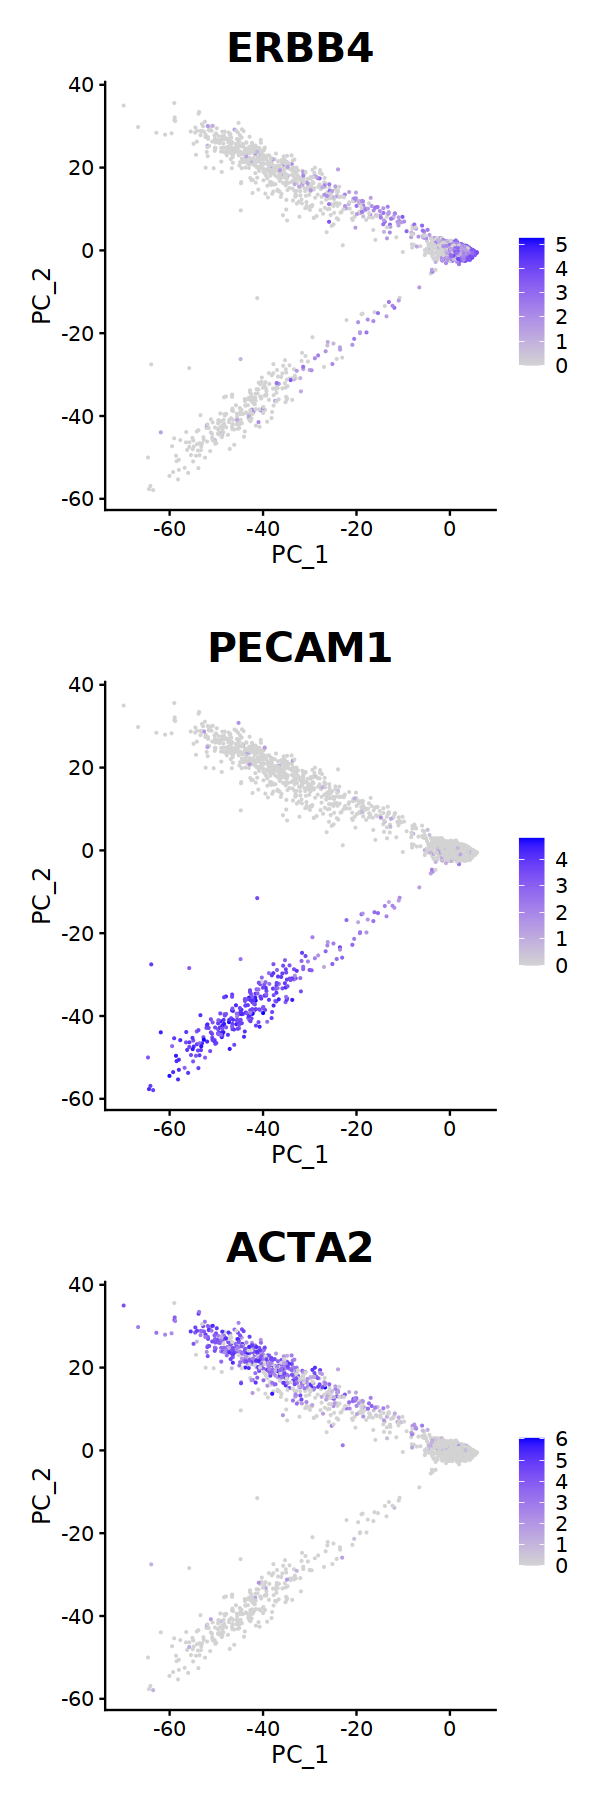

In [41]:
options(repr.plot.width = 5, repr.plot.height = 15, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(plotlist = plts,
                   align = "hv",
                   axis = "trbl",
                   ncol = 1,
                   nrow = 3)
cp

## UMAP representation

In [18]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:20,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

16:48:22 UMAP embedding parameters a = 0.9922 b = 1.112

16:48:22 Read 18258 rows and found 20 numeric columns

16:48:22 Using Annoy for neighbor search, n_neighbors = 30

16:48:22 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:48:24 Writing NN index file to temp file /scratch_tmp/37720702/RtmpEiWMtX/file10e8c15b2ab13

16:48:24 Searching Annoy index using 1 thread, search_k = 3000

16:48:30 Annoy recall = 100%

16:48:30 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:48:32 Initializing from normalized Laplacian + noise (using irlba)

16:48:32 Commencing optimization for 200 epochs, with 778286 positive edges

16:48:52 Optimization finished



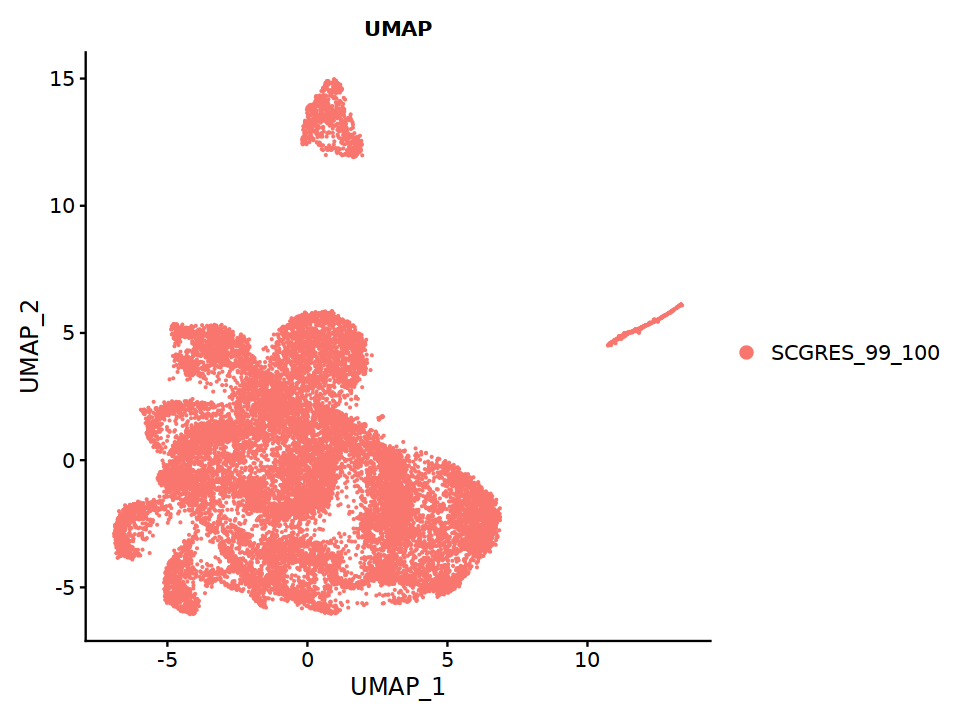

In [19]:
options(repr.plot.width = 8, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  pt.size = 0.1
) + ggtitle('UMAP') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

## More quality checks on UMAPs

### Compute Cell-Cycle Scores

In [20]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
seurat_obj <- CellCycleScoring(seurat_obj, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

### Plot several features

In [21]:
cat_vars <-c("Phase")
con_vars <- c("nCount_RNA", "nFeature_RNA", "pct_mt", "percent.ribo", 
              "doublet_score", "PTPRC", "COL1A2", "SMARCB1", "TOP2A")
vars <- c(cat_vars, con_vars)

In [22]:
# compute plots
list_plots <- lapply(vars, function(var){
  if (var %in% cat_vars) {
      p <- DimPlot(seurat_obj, reduction = "umap", group.by=var)
  } else {
      p <- FeaturePlot(seurat_obj, reduction = "umap", feature=var, order = TRUE)
  }
  return(p)
})

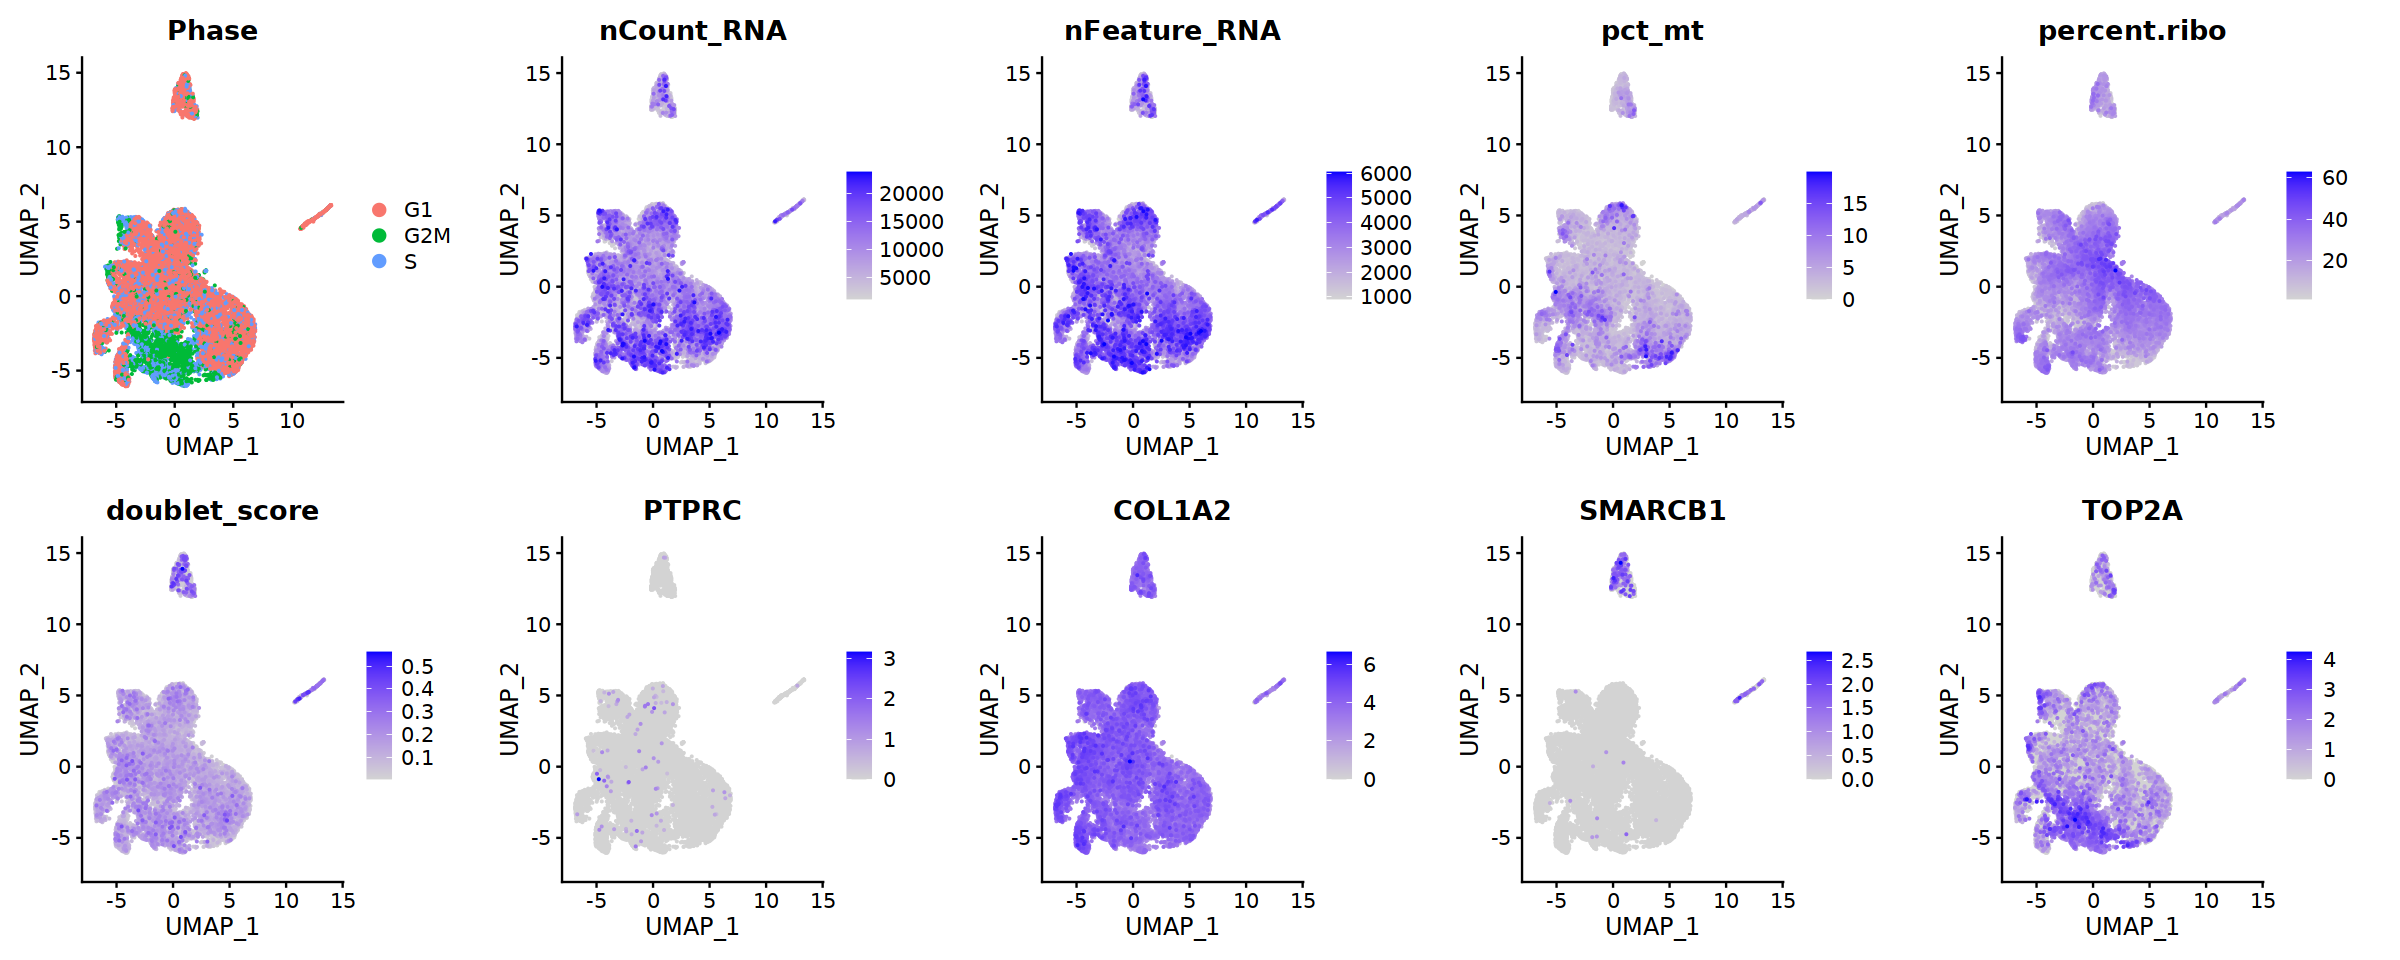

In [23]:
options(repr.plot.width = 20, repr.plot.height = 8, warn=-1,verbose = FALSE)
# show plots
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol = 5,
                   nrow = 2)
cp

# Save

In [24]:
saveRDS(seurat_obj, here::here(glue::glue("{clust}/{robj_dir}/dimred_combined_object_T0_CD45neg.rds")))

# Session Info

In [25]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scran_1.22.1                scater_1.22.0              
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_